In [148]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

In [196]:
%matplotlib inline

## Create necessary classes and functions

Create class to handle "cities"

In [149]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"
    
    def as_tuple(self):
        return (self.x,self.y)

Create a fitness function

In [150]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Create our initial population

Route generator

In [151]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

Create first "population" (list of routes)

In [152]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

## Create the genetic algorithm

Rank individuals

In [153]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

Create a selection function that will be used to make the list of parent routes

In [154]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Create mating pool

In [155]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Create a crossover function for two parents to create one child

In [156]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Create function to run crossover over full mating pool

In [157]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

Create function to mutate a single route

In [158]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Create function to run mutation over entire population

In [159]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Put all steps together to create the next generation

In [160]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

Plotting

In [202]:
def plot(route):
    xs = [x.as_tuple()[0] for x in route]
    xs.append(route[0].as_tuple()[0]) # add first city to the end to create a loop
    ys = [x.as_tuple()[1] for x in route]
    ys.append(route[0].as_tuple()[1]) # add first city to the end to create a loop
    plt.plot(xs, ys)
    plt.show()

Final step: create the genetic algorithm

In [214]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
        if i % 50 == 0:
            best_of_pop = rankRoutes(pop)[0]
            print("Best distance for generation %d: %f" %(i, 1 / best_of_pop[1]))
            plot(pop[best_of_pop[0]])
    
    best_of_pop = rankRoutes(pop)[0]
    print("Final distance: " + str(1 / best_of_pop[1]))
    bestRouteIndex = best_of_pop[0]
    bestRoute = pop[bestRouteIndex]
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()
    return bestRoute

## Running the genetic algorithm

Create list of cities

In [204]:
cityList = []
for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

Run the genetic algorithm

Initial distance: 2041.0189949419691
Best distance for generation 0: 2041.018995


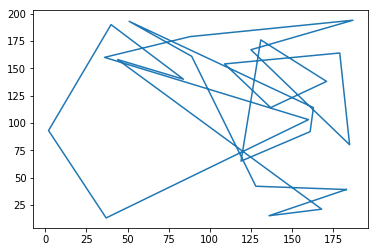

Best distance for generation 100: 1013.765804


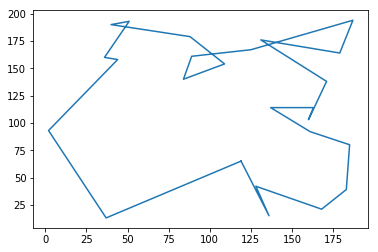

Best distance for generation 200: 901.655902


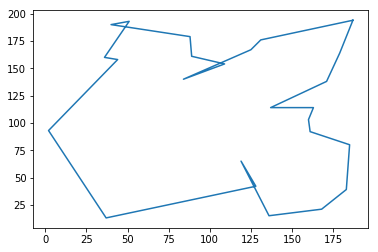

Best distance for generation 300: 850.515092


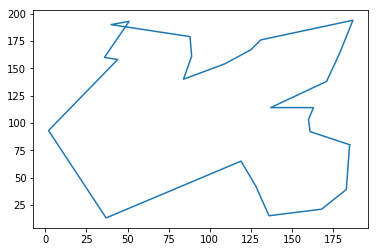

Best distance for generation 400: 834.847237


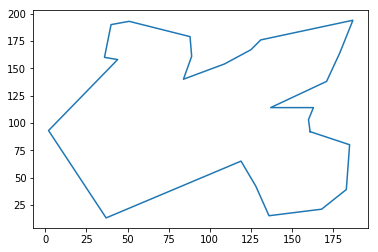

Best distance for generation 500: 834.575362


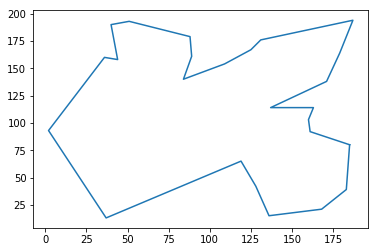

Final distance: 834.5753618405857


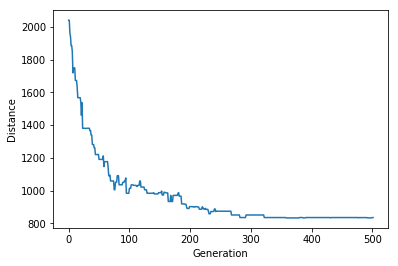

In [185]:
bestRoute = geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=501)

In [204]:
cityList = []
for i in range(0,35):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

Initial distance: 2871.8514954597495
Best distance for generation 0: 2834.146719


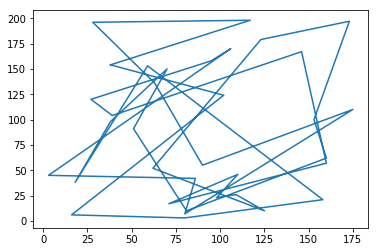

Best distance for generation 50: 1886.135797


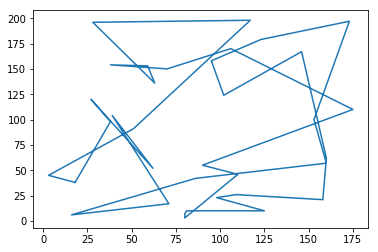

Best distance for generation 100: 1639.584754


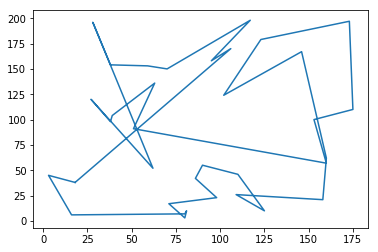

Best distance for generation 150: 1443.957598


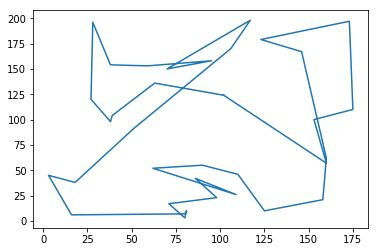

Best distance for generation 200: 1434.031954


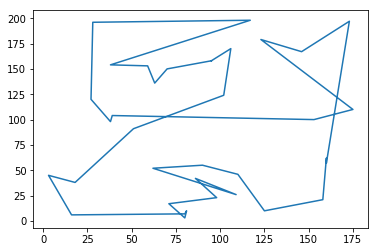

Best distance for generation 250: 1321.865125


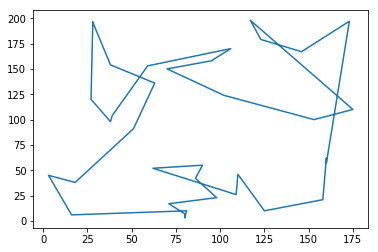

Best distance for generation 300: 1429.891663


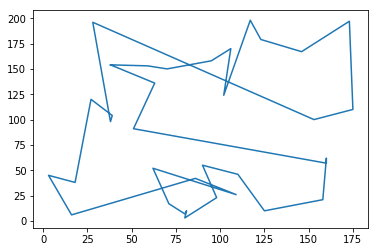

Best distance for generation 350: 1366.464851


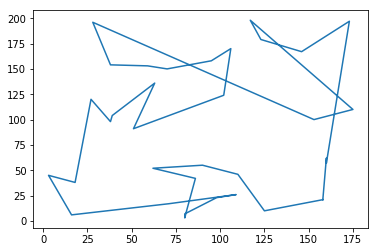

Best distance for generation 400: 1290.238284


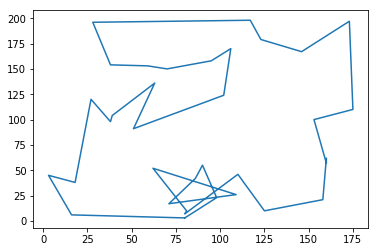

Best distance for generation 450: 1287.015825


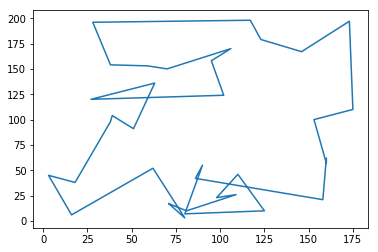

Best distance for generation 500: 1194.698529


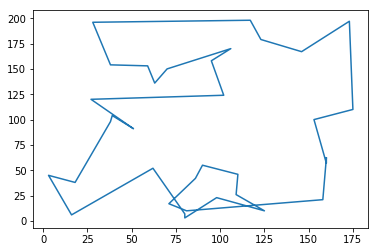

Best distance for generation 550: 1138.064469


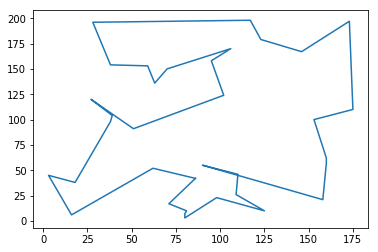

Best distance for generation 600: 1171.876418


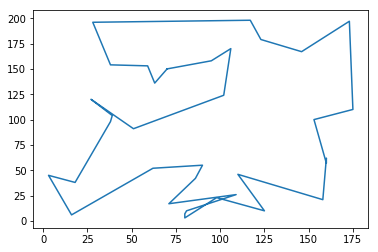

Best distance for generation 650: 1156.057772


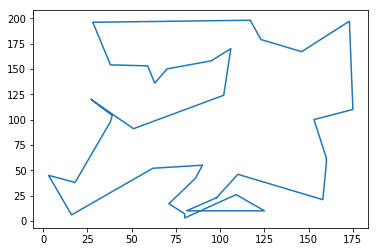

Best distance for generation 700: 1125.419562


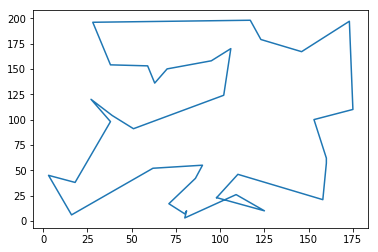

Final distance: 1125.4195623115274


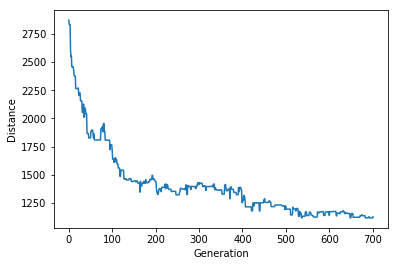

In [213]:
bestRoute = geneticAlgorithm(population=cityList, popSize=200, eliteSize=20, mutationRate=0.01, generations=701)